In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100
})



from Finite_volume_method_1D import *

In [3]:
chippath = '../../DataKian/bTa_LT278W2chip5/'
filename = 'KID3_96dBm__TmK20_avgpulse_ampphase.csv'
length = 90
simtime = 300

lambdasinnm = [402]
KIDdict = {}
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(start=200,showplots=False)

In [4]:
Ls=[]
for lambdanm in lambdasinnm:
    print(KIDdict[lambdanm].tauqpstar,KIDdict[lambdanm].tauqpstarstd)
    print(KIDdict[lambdanm].L)
    Ls.append(KIDdict[lambdanm].L)
L=np.mean(Ls)

194.88850185176454 2.2767849027049727
0.005131139038467322


In [5]:
def prep_data(neg_offset):
    ylist = []
    for lambdanm in lambdasinnm:
        xfit = np.arange(neg_offset,neg_offset+simtime-KIDdict[lambdanm].dt/2,KIDdict[lambdanm].dt)
        indmin = np.argmax(KIDdict[lambdanm].phase)+neg_offset
        indmax = indmin + simtime
        ylist.append(KIDdict[lambdanm].phase[indmin:indmax])
    yfit = np.array(ylist).ravel()
    return xfit, yfit

def func_to_parallelize(t,params):
     SIM = KID_sim(params,0.001,1/4,simtime_approx=simtime,D_const=False)
     return np.interp(t,SIM.t_axis_interp,SIM.phaseintime)

def fitfunc(t,dthetadN,Q0):
    datalist = Parallel(n_jobs=len(lambdasinnm))(delayed(func_to_parallelize)(t,KID_params(eta_pb=consts.eta_pb_max,sigma_IC=10,dthetadN=dthetadN,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    return np.concatenate(datalist)

def parallelize_plot(params):
     SIM = KID_sim(params,0.001,1/4,simtime_approx=simtime,D_const=False)
     return SIM

def plotsim(dthetadN,Q0):
    datalist = Parallel(n_jobs=4)(delayed(parallelize_plot)(KID_params(eta_pb=consts.eta_pb_max,sigma_IC=10,dthetadN=dthetadN,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    plotdata = {}
    for obj,lambdanm in zip(datalist,lambdasinnm):
         plotdata[lambdanm]=obj
    return plotdata

In [6]:
xfit,yfit=prep_data(-1) #-5 means take 5 data points before the max into account for the data
popt, pcov = curve_fit(fitfunc,xfit,yfit,p0=[1e-4,0.5],bounds=[[1e-9,1e-9],[np.inf,np.inf]])

 99%|█████████▉| time (us): 300.3018906350689   
 99%|█████████▉| time (us): 300.3018906350689  
 99%|█████████▉| time (us): 300.30184967025696 
 99%|█████████▉| time (us): 300.1144448672901  
 99%|█████████▉| time (us): 300.0243990511521   
 99%|█████████▉| time (us): 300.0243990511521   
 99%|█████████▉| time (us): 300.0243491850203   
 99%|█████████▉| time (us): 300.3736596883784  
 99%|█████████▉| time (us): 300.3736596883784  
 99%|█████████▉| time (us): 300.37359110161606  
100%|█████████▉| time (us): 300.59525771955737  
100%|█████████▉| time (us): 300.59525771955737  
100%|█████████▉| time (us): 300.5951775073472   
 99%|█████████▉| time (us): 300.0214044900936   
 99%|█████████▉| time (us): 300.21598159573233 
 99%|█████████▉| time (us): 300.21598159573233 
 99%|█████████▉| time (us): 300.21590180802116 
 99%|█████████▉| time (us): 300.3976611105049   
 99%|█████████▉| time (us): 300.3976611105049  
 99%|█████████▉| time (us): 300.39758184365735  
 99%|█████████▉| time (us): 3

In [13]:
# Display parameters, standard deviation, and correlation coefficient
parameters = ['dthetadN','Q0','sigma']
print("Parameters:")
for name, param, std in zip(parameters,popt,np.sqrt(np.diag(pcov))):
    print(f"{name}:\t{param:.10f}\t+/-\t{std:.10f}")

print("\nCorrelation Coefficients:")
for i in range(len(popt)):
    for j in range(i+1, len(popt)):
        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.10f}")

Parameters:
dthetadN:	0.0001504461	+/-	0.0000184122
Q0:	0.2866732095	+/-	0.0541280500

Correlation Coefficients:
dthetadN vs Q0: -0.9579210914


In [14]:
#D variable
'''
dthetadN:	0.0001027850	+/-	0.0003031967
Q0:	0.3280079318	+/-	0.9464581679
sigma:	178.5681327840	+/-	20921459.8417598680

Correlation Coefficients:
dthetadN vs Q0: -0.9996530927
dthetadN vs sigma: -0.9994529472
Q0 vs sigma: 0.9985152834
'''

simdata = plotsim(popt[0],popt[1])

100%|█████████▉| time (us): 300.5564728733479   
 99%|█████████▉| time (us): 300.08925439366294
 99%|█████████▉| time (us): 300.28790522769225
 99%|█████████▉| time (us): 300.1693021369977 


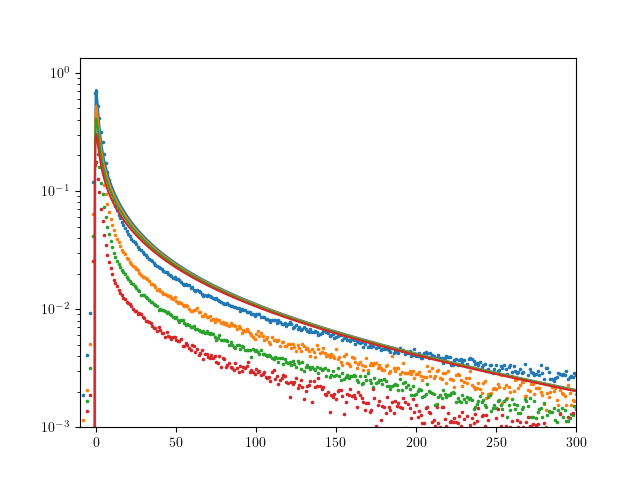

In [20]:
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.semilogy(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime)
    plt.scatter(t,phase,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,300)
plt.ylim(1e-3)
plt.show()

In [16]:
chippath = '../../DataKian/bTa_LT278W2chip5/'
filename = 'KID3_96dBm__TmK20_avgpulse_ampphase.csv'
length = 90
simtime = 300

lambdasinnm = [402,673,986,1545]
KIDdict = {}
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(start=200,showplots=False)
L=KIDdict[402].L

simdata = plotsim(popt[0],popt[1])

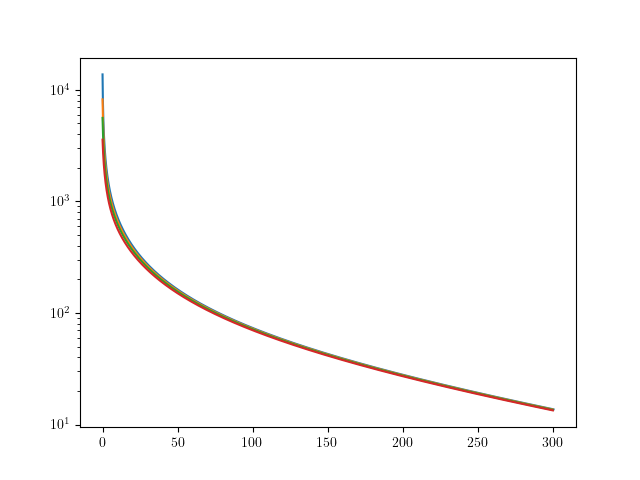

In [31]:
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    maxi = np.max(simdata[lambdanm].Nqpintime)
    plt.semilogy(simdata[lambdanm].t_axis,simdata[lambdanm].Nqpintime)
plt.show()

In [12]:
for lambdanm in lambdasinnm:
    np.savetxt(f"data_D_const_20_{lambdanm}.csv", np.c_[simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime] , delimiter=',', header="time (us), phase (rad)", comments="")

In [26]:
simdata[402].D_const

AttributeError: 'KID_sim' object has no attribute 'D_const'